In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# Fixed-budget optimisation mode

**N.B. Currently this is only developed for panel based detectors.**

The previous examples worked under the assumption of building a detector and considering the cost of it as part of the loss, i.e the final detector may be vastly under, or slightly over budget. TomOpt has a new mode in which the detector can be fixed to always cost the same. This is performed via a learned assignment of the budget distribution:
1. The `Volume` is intialisaed with a budget
1. The `Volume` then collects all the different costs across all detector components and treats their fractional assignment of the total budget as a learnable parameter (softmax is used to normalise the fractional assignment). The budget assignment is currently initialised such that every element gets and equal fraction.
1. During the forward propagation of muons, the detectors receive their allocated budget and are then responsible for allocating to their costs: i.e. a `PanelDetectorLayer` with 4 `DetectorPanel`s will receive four budgets, one for each panel.
1. `DetectorPanel`s still learn an `xy_span` as normal, but this is then rescaled according to their allocated budget and their prescribed cost per $m^2$

In this way a detector always costs the specified budget, and panels and grow or shrink in size according to their 'importance', i.e. a less important panel can be more easily shrunk to allow it's budget to be allocated to more important panels.

In [2]:
from tomopt.core import *

/Users/giles/anaconda3/envs/tomopt/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import torch
from torch import Tensor
from torch.nn import functional as F

import matplotlib.pyplot as plt
import seaborn as sns

/Users/giles/anaconda3/envs/tomopt/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [4]:
DEVICE = torch.device('cpu')

Construct a volume by sandwiching passive layers with pairs of detector layers above and below. Detector panels are initialised with specified parameters, but the number of detector panels per layer is fixed. Passive layers will contain voxels of different materials.

In [5]:
import numpy as np
from torch import nn
from tomopt.volume import PassiveLayer, PanelDetectorLayer, DetectorPanel

In [6]:
def get_layers():
    layers = []
    lwh = Tensor([1,1,1])
    size = 0.1
    init_eff = 0.9
    init_res = 1e4
    n_panels = 4
    layers.append(PanelDetectorLayer(pos='above', lw=lwh[:2], z=1, size=2*size,
                                     panels=[DetectorPanel(res=init_res, eff=init_eff,
                                                      init_xyz=[0.0,0.0,1-(i*(2*size)/n_panels)], init_xy_span=[0.5,0.5],
                                                      m2_cost=1, device=DEVICE) for i in range(n_panels)]))
    for z in [0.8,0.7,0.6,0.5,0.4,0.3]:
        layers.append(PassiveLayer(lw=lwh[:2], z=z, size=size, device=DEVICE))
    layers.append(PanelDetectorLayer(pos='below', lw=lwh[:2], z=0.2, size=2*size,
                                     panels=[DetectorPanel(res=init_res, eff=init_eff,
                                                      init_xyz=[0.0,0.0,0.2-(i*(2*size)/n_panels)], init_xy_span=[0.5,0.5],
                                                      m2_cost=1, device=DEVICE) for i in range(n_panels)]))

    return nn.ModuleList(layers) 

In [7]:
from tomopt.volume import Volume

Note when initialising the `Volume` we specify the budget. Even though the above function specifies that panels should be 1x1 m in size, the budget rescaling doubles this to 2x2 m

In [8]:
volume = Volume(get_layers(), budget=32)
volume

Volume(
  (layers): ModuleList(
    (0): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0., 0.]), z=tensor([1.]), and xy span tensor([2., 2.]) with budget scale 4.0
        (1): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0., 0.]), z=tensor([0.9500]), and xy span tensor([2., 2.]) with budget scale 4.0
        (2): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0., 0.]), z=tensor([0.9000]), and xy span tensor([2., 2.]) with budget scale 4.0
        (3): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0., 0.]), z=tensor([0.8500]), and xy span tensor([2., 2.]) with budget scale 4.0
      )
    )
    (1): PassiveLayer located at z=tensor([0.8000])
    (2): PassiveLayer located at z=tensor([0.7000])
    (3): PassiveLayer located at z=tensor([0.6000])
    (4): PassiveLayer located at z=tensor([0.5000])
    (5): PassiveLayer located at z=tensor([0.4000])
 

In [9]:
volume.get_cost()

tensor(32)

We can inspect the budget weights in the volume, which currently gives each of the 8 panels the same fraction of total budget

In [10]:
volume.budget_weights

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

In [11]:
F.softmax(volume.budget_weights, dim=-1)*volume.budget

tensor([4., 4., 4., 4., 4., 4., 4., 4.], grad_fn=<MulBackward0>)

The `xy_span` parameter of panels doesn't account for the budget, instead the `get_scaled_xy_span` function may be used:

In [12]:
p = volume.get_detectors()[0].panels[0]
p.xy_span, p.get_scaled_xy_span()

(Parameter containing:
 tensor([0.5000, 0.5000], requires_grad=True),
 tensor([2., 2.], grad_fn=<MulBackward0>))

## Optimisation

When optimising in fixed-budget mode, we introduce a new optimiser, `budget_opt`, to adjust the `budget_weights` parameter.

For this example, we'll study the ULorry benchmark, in which we generate volumes with scarp metal present and maybe a small block of uranium, the presence of which we infer using a hypothesis-based summary statistic.

In [13]:
from tomopt.benchmarks.u_lorry import *
from tomopt.optimisation import PassiveYielder

In [14]:
u_volume = 0.012
passive_gen = ULorryPassiveGenerator(volume, u_volume=u_volume, u_prob=0.5, fill_frac=0.8, x0_lorry=X0['iron'], bkg_materials=['air', 'iron'])
trn_passives = PassiveYielder(passive_gen, n_passives=4)

/Users/giles/cernbox/mode_muon_tomography/tomopt/benchmarks/u_lorry/data.py:38: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  szs = torch.combinations(torch.arange(1, max_n + 1), r=3, with_replacement=True)


In [15]:
from functools import partial
from tomopt.inference import DenseBlockClassifierFromX0s, PanelX0Inferrer
from tomopt.optimisation import PanelVolumeWrapper, VolumeClassLoss

In [16]:
from tomopt.optimisation import NoMoreNaNs, PanelMetricLogger, CostCoefWarmup, PanelOptConfig, MuonResampler

In [17]:
wrapper = PanelVolumeWrapper(volume,
                             xy_pos_opt=partial(torch.optim.SGD, lr=12),
                             z_pos_opt=partial(torch.optim.SGD, lr=0.01),
                             xy_span_opt=partial(torch.optim.SGD, lr=0),
                             budget_opt=partial(torch.optim.SGD, lr=1e1),
                             loss_func=VolumeClassLoss(x02id={0:0, 1:1}, target_budget=None),
                             partial_volume_inferrer=partial(DenseBlockClassifierFromX0s, n_block_voxels=u_volume, partial_x0_inferrer=PanelX0Inferrer, volume=volume, ratio_offset=-1, ratio_coef=1))

`PanelOptConfig` can also be used to learn a suitable learning rate for the budget optimiser. Since we expect that the optimal shape of the panels to be reasonably square, we can set the desired rate of the xy_span to be 0, such that we do not learn it and the panels remain square.

1 warmup callbacks found, with a total warmup period of 5 epochs.


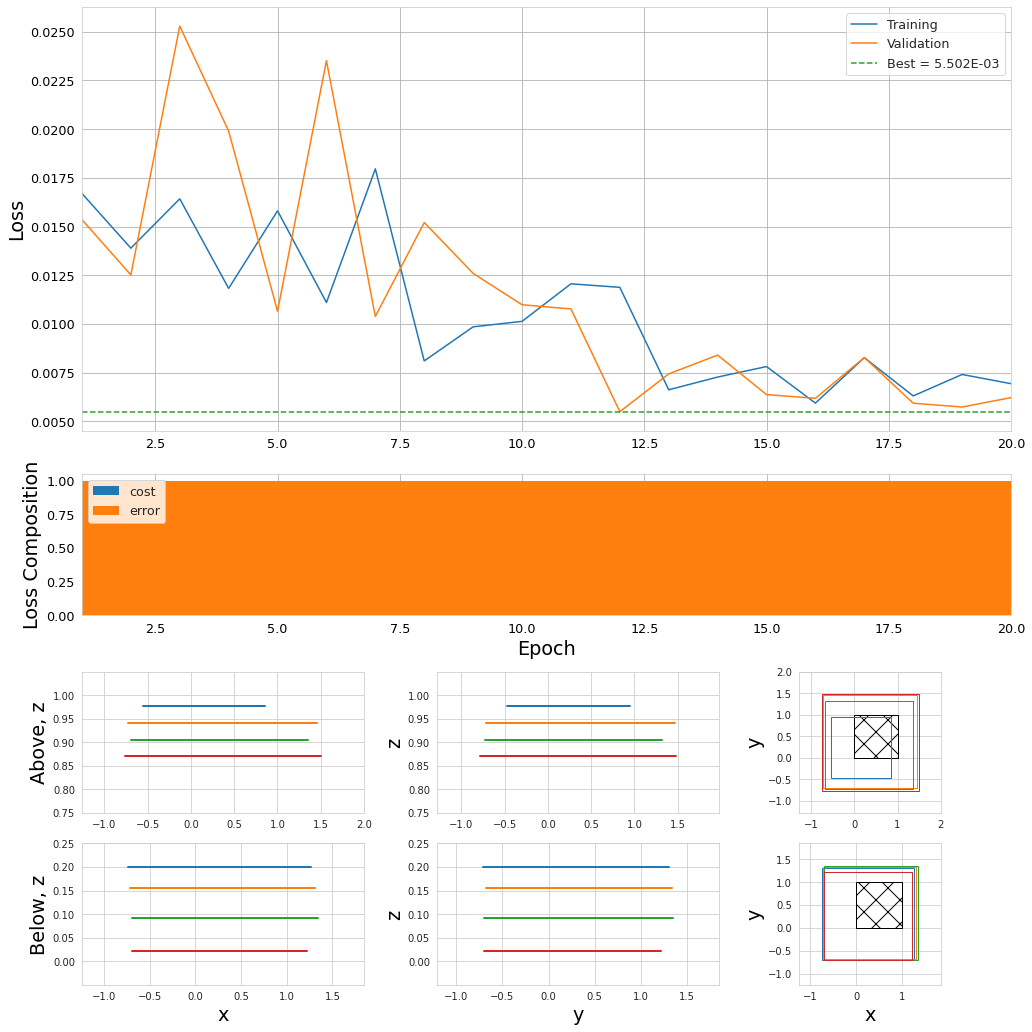

Automatically setting cost coefficient to 0.023486820980906487


/Users/giles/cernbox/mode_muon_tomography/tomopt/optimisation/callbacks/monitors.py:217: UserWarning: Attempting to set identical left == right == 1.0 results in singular transformations; automatically expanding.
  ax.set_xlim(1 / self.n_trn_batches, x[-1])


PanelOptConfig: Optimiser warm-up completed
+------------+---------------+-----------------------+
|   Param    |  Median Grad  |           LR          |
+------------+---------------+-----------------------+
| xy_pos_opt |  0.0038644387 |   12.938489488685077  |
| z_pos_opt  |   0.8020403   | 0.0012468201738658946 |
| budget_opt | 0.00029588107 |   337.9736375407765   |
+------------+---------------+-----------------------+


<Figure size 1024x1024 with 0 Axes>

In [18]:
_ = wrapper.fit(n_epochs=20,
                passive_bs=4,
                n_mu_per_volume=250,
                mu_bs=250,
                trn_passives=trn_passives,
                val_passives=trn_passives,
                cbs=[PanelOptConfig(n_warmup=5, xy_pos_rate=0.05, z_pos_rate=0.001, budget_rate=0.1),
                     MuonResampler(), NoMoreNaNs(),PanelMetricLogger()])

We can see how the budget assignment changed:

In [19]:
volume.budget_weights

Parameter containing:
tensor([-0.6626,  0.2037,  0.0680,  0.2762,  0.0424,  0.0507,  0.0746, -0.0531],
       requires_grad=True)